### Approach:
1. Working with session data (Views, ATB, purchases).   
2. **Views, ATB and Purchases**  
3. Cleaning the data  
4. Removing duplicate productids occuring consecutively as having the same productid does not capture any information for our word2vec model.   
5. Using Pytorch for word2vec algorithm. 
6. Finding the word embeddings of each productid and computing the cosine similarity of the vectors to generate the top 15 recommendations for an anchor product. 



**Install the requirements**     
 Numpy, Pandas, iPython-autotime, Gensim, pyarrow, pytorch `cd work/a127669/` and `sudo pip install -r requirements.txt`  
 Product visualization ```cd src/mml-lib``` and ```sudo pip install -e .```    
 Recommendation evaluator ```cd src/recom-evaluator``` and ```sudo pip install -e .``` 

In [1]:
import sys
sys.path.append('/home/jovyan/work/a091569/RECOM_LIBS/recom-evaluator')
sys.path.append('/home/jovyan/work/a091569/RECOM_LIBS/mml-lib')

In [3]:
import numpy as np
import itertools, logging
np.random.seed(12345)
%load_ext autotime
import warnings
warnings.filterwarnings('ignore')
import os, sys
import pandas as pd
from multiprocessing import  Pool
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import heapq
#from mml_lib.visualization import display_recom_panel, display_product
import recomevaluator.run_all as evaluate_recoms
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from mml_lib.datasets import get_datacollection

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.93 ms


## 1. Loading the data
   i) **Fetching from the data collection**  
Don't run this if you already have the parquet files (.gzip)

In [3]:
!ls -d /home/jovyan/datasets/d_train_2019*_0

/home/jovyan/datasets/d_train_20190402_60_0
/home/jovyan/datasets/d_train_20190403_60_0
/home/jovyan/datasets/d_train_20190417_60_0
/home/jovyan/datasets/d_train_20190506_60_0
/home/jovyan/datasets/d_train_20190605_60_0
/home/jovyan/datasets/d_train_20190606_35_0
/home/jovyan/datasets/d_train_20190607_45_0
/home/jovyan/datasets/d_train_20190723_120_0
/home/jovyan/datasets/d_train_20190723_45_0
/home/jovyan/datasets/d_train_20190723_60_0
/home/jovyan/datasets/d_train_20190723_90_0
/home/jovyan/datasets/d_train_20190810_22_0
time: 635 ms


In [4]:
MIN_VIEW_EVENTS = 2
MIN_ATB_EVENTS = 1
MIN_PURCHASE_EVENTS = 0

dc = get_datacollection('/home/jovyan/datasets/d_train_20190810_22_0/')(verbose=True)

views = dc.view_events.groupby(['indiv_id'])['product_id'].apply(list)
views = views[views.map(len) > MIN_VIEW_EVENTS]
views = views.to_frame()

atb = dc.atb_events.groupby(['indiv_id'])['product_id'].apply(list)
atb = atb[atb.map(len) > MIN_ATB_EVENTS]
atb = atb.to_frame()

purchase = dc.purchase_events.groupby(['indiv_id'])['product_id'].apply(list)
purchase = purchase[purchase.map(len) > MIN_PURCHASE_EVENTS]
purchase = purchase.to_frame()

view_atb = views.join(atb, on='indiv_id', lsuffix='_views', rsuffix='_atb') 
common_events = view_atb.join(purchase, on='indiv_id', rsuffix = '_purchase')

Using dataset /home/jovyan/datasets/d_train_20190810_22_0
Loading view events...
loaded 238641154 events.
Loading atb events...
loaded 64924676 events.
Loading purchase events...
loaded 6322456 events.
time: 34min 42s


**Save the dataframe to parquet file to load it faster than from a csv.** 


In [6]:
def save_df_as_parquet_file(dataframe, filename):
    path = '/home/jovyan/work/a091569/DTOOLS/DATA'
    parquet_file = os.path.join(path,'{}.gzip'.format(filename))
    dataframe.to_parquet(parquet_file ,compression='gzip')


time: 1.45 ms


In [ ]:
save_df_as_parquet_file(views, 'views_20190810_22')
save_df_as_parquet_file(atb, 'atb_20190810_22')
save_df_as_parquet_file(purchase, 'pur_20190810_22')

In [ ]:
save_df_as_parquet_file(view_atb, 'view_atb_20190810_22')
save_df_as_parquet_file(common_events, 'common_events_20190810_22')

ii) **Loading the data from the parquet file**

In [5]:
!ls /home/jovyan/work/a091569/DTOOLS/DATA

atb_20190810_22.gzip		view_atb_20190810_22.gzip
common_events_20190810_22.gzip	views_20190810_22.gzip
pur_20190810_22.gzip
time: 2.07 s


In [ ]:
common_events = pd.read_parquet('/home/jovyan/work/a091569/DTOOLS/DATA/common_events_20190810_22.gzip')
view_atb = pd.read_parquet('/home/jovyan/work/a091569/DTOOLS/DATA/view_atb_20190810_22.gzip')
views = pd.read_parquet('/home/jovyan/work/a091569/DTOOLS/DATA/views_20190810_22.gzip')
atb = pd.read_parquet('/home/jovyan/work/a091569/DTOOLS/DATA/atb_20190810_22.gzip')
pur = pd.read_parquet('/home/jovyan/work/a091569/DTOOLS/DATA/pur_20190810_22.gzip')

In [ ]:
#((1898005, 3), (1898005, 1), (823011, 1), (482362, 1))

In [7]:
common_events.shape, view_atb.shape, views.shape, atb.shape, pur.shape

((5169076, 3), (5169076, 2), (5169076, 1), (3460588, 1), (1860148, 1))

time: 6.02 ms


In [8]:
views.head()

,product_id
indiv_id,
1000000195,"[7284138, 7284138, 8899946, 8997974, 8997974, ..."
1000000406,"[8018903, 8768312, 8018899, 1369276, 8768312, ..."
1000000635,"[9758432, 7108561, 7825808, 6351408, 9651372]"
1000000722,"[5729552, 1633215, 5729552, 5729552, 5729552, ..."
1000000819,"[1207174, 2563637, 2563637, 2563637, 2563637, ..."


time: 21 ms


In [17]:
views.iloc[0].values

array([array(['7284138', '7284138', '8899946', '8997974', '8997974', '6751215',
       '6402625', '1346528', '5347769', '6402625', '9950844', '9308182',
       '8024321', '6402625', '8174568', '6402625', '9926953', '6402625',
       '8174568', '6453662', '2618336', '8217876', '8217876', '4915972'],
      dtype=object)], dtype=object)

time: 5.5 ms


In [9]:
atb.head()

,product_id
indiv_id,
1000000195,"[8217876, 8217876, 8217876]"
1000000635,"[7108561, 6351408, 6351408, 7108561, 7825808, ..."
1000000722,"[1633215, 5729552, 1633215, 1633215, 5729552, ..."
1000001145,"[9348686, 9348686, 9348690, 9348690, 8277626, ..."
1000001315,"[7270860, 7270860, 7270860, 7270860]"


time: 10.9 ms


In [10]:
pur.head()

,product_id
indiv_id,
1000000195,[8217876]
1000000635,"[6351408, 7825808]"
1000000722,"[5729552, 1633215]"
1000001145,"[1622049, 8774636, 8774632, 9463656, 9463656, ..."
1000001315,[7270860]


time: 9.43 ms


In [11]:
common_events.head()

,product_id_views,product_id_atb,product_id
indiv_id,,,
1000000195,"[7284138, 7284138, 8899946, 8997974, 8997974, ...","[8217876, 8217876, 8217876]",[8217876]
1000000406,"[8018903, 8768312, 8018899, 1369276, 8768312, ...",None,None
1000000635,"[9758432, 7108561, 7825808, 6351408, 9651372]","[7108561, 6351408, 6351408, 7108561, 7825808, ...","[6351408, 7825808]"
1000000722,"[5729552, 1633215, 5729552, 5729552, 5729552, ...","[1633215, 5729552, 1633215, 1633215, 5729552, ...","[5729552, 1633215]"
1000000819,"[1207174, 2563637, 2563637, 2563637, 2563637, ...",None,None


time: 18 ms


## 2. Data Preparation

**Remove the productids which appear consecutively in a session**  
session: 123, 345, 567, 567, 231, 345, 345 to  session: 123, 345, 567, 231, 345

In [ ]:
# parallelized code
def remove_duplicate_productids(data):
    #applies the function on each value of the pandas series
    res = data.product_id.apply(loop)
    return res

In [ ]:
def loop(row):
    last = -1
    index = -1
    

    List = list(row)

    '''
    Splits the sessions into subsessions based on category and removes productids from the list occuring in a sequence
    session: 123, 345, 567, 567, 231, 345, 345 to  session: 123, 345, 567, 231, 345
    '''

    for i in list(row):

        # index keeps check of the index of the product in the list
        index +=1
        # when the two consecutive productids are equal
        if i == last:
            # remove the latest occurence of the productid
            List.pop(index)
            # as the product is removed from the list. Decrement the index value
            index -=1
        # update the last element visited
        last = i  

    return List

    


In [ ]:
def parallelize(df, func, n_cores=10):
    '''
    The dataframe is split into n_cores and remove_duplicate_productids is performed on each sub dataframe
    n_cores: No of processors (96 in this env)
    n_cores is taken as 10 as it takes less time to split the given data.
    '''
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df
  

In [ ]:
de_duped_views = parallelize(views, remove_duplicate_productids)
de_duped_atb = parallelize(atb, remove_duplicate_productids)
de_duped_pur = parallelize(pur, remove_duplicate_productids)

**After removing the product ids appearing in a sequence. Store it inplace**

In [ ]:
views.product_id_views = pd.Series(de_duped_views)
atb.product_id_atb = pd.Series(de_duped_atb)
pur.product_id_pur = pd.Series(de_duped_pur)

**Load the product catalog info**

In [ ]:
#d_train_20190506_60_5449
df = pd.read_csv("/home/jovyan/datasets/d_train_20190810_22_0/ur_production_product_attr.csv", sep='\t')

In [ ]:
df.head(2)

**Availability filter**  
**No of available products in our catalog**

In [ ]:
s = df.groupby(['availability_flag'])['availability_flag'].count()
print("Available products: " +str(s[0]))
print("Total products: " +str(s[0] + s[1]))
print("Ratio of available products to total prods: " +str(s[0]/(s[0]+s[1])))


In [ ]:
def prod_availability_dict(data):
    '''
    Create a dictionary to store the productid and its availabilty_flag
    Helps in filtering the sessions based on availability
    '''
    dict = {}
    for index, col in data.iterrows():
        if col['availability_flag'] == 'Y':
            dict[col['product_id']] = col['availability_flag']
    return dict

In [ ]:
available_dict = prod_availability_dict(df)

In [ ]:
# parallelized code
def availability_filter(data):
    # applies the function on each value of the pandas series
    res = data.product_id.apply(filtering)
    return res

In [ ]:
def filtering(col):
    '''
    Filters the sessions by the available products
    Args: Each row of the dataframe
    
    Returns: Filtered session with prod ids which are available
    '''
    last = -1
    index = -1
    List = list(col)
    
    for i in list(col):
        if int(i) in available_dict:
            pass
        else:
            List.remove(i)
       
    return List        

In [ ]:
def parallelize_availabilty(df, func, n_cores=10):
    '''
    The dataframe is split into n_cores and availability_filter is performed on each sub dataframe
    n_cores: No of processors (96 in this env)
    n_cores is taken as 10 as it takes less time to split the given data.
    
    Args: df: Dataframe
          func: The function which has to be parallelized
    Returns: Dataframe
    '''
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df
  

In [ ]:
l1 = parallelize_availabilty(views, availability_filter)
l2 = parallelize_availabilty(atb, availability_filter)
l3 = parallelize_availabilty(pur, availability_filter)

**After filtering the sessions with only available prods. Store it inplace**

In [ ]:
views.product_id = pd.Series(l1)
atb.product_id = pd.Series(l2)
pur.product_id = pd.Series(l3)

**List of count of events in a sessions**

In [ ]:
lengths_of_view_events = views.product_id.map(len)
lengths_of_atb_events = atb.product_id.map(len)
lengths_of_pur_events = pur.product_id.map(len)

**Identify outliers**

In [ ]:
def outlier_detection(lengths_of_events):
    # identify outliers with interquartile range
    from numpy.random import seed
    from numpy.random import randn
    from numpy import percentile
    # seed the random number generator
    seed(1)
    # generate univariate observations
    data = np.array(lengths_of_events)
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    return outliers

In [ ]:
view_outliers = outlier_detection(lengths_of_view_events)

In [ ]:
atb_outliers = outlier_detection(lengths_of_atb_events)

In [ ]:
pur_outliers = outlier_detection(lengths_of_pur_events)

**Get the threshold values to remove the sessions with event count greater than the threshold**

In [ ]:
threshold_count_views = min(view_outliers)
threshold_count_atb = min(atb_outliers)
threshold_count_pur = min(pur_outliers)

In [ ]:
print('Threshold no of views {}'.format(threshold_count_views))
print('Threshold no of atb {}'.format(threshold_count_atb))
print('Threshold no of pur {}'.format(threshold_count_pur))

In [ ]:
views = views[views['product_id'].map(len) < threshold_count_views]
atb = atb[atb['product_id'].map(len) < threshold_count_atb]
pur = pur[pur['product_id'].map(len) < threshold_count_pur]

**Merge the data**

In [ ]:
view_atb = views.join(atb, on='indiv_id', lsuffix='_views', rsuffix='_atb') 
common_events = view_atb.join(purchase, on='indiv_id', rsuffix = '_purchase')

In [ ]:
common_events.head()

In [ ]:
data = common_events.copy()

**Removing rows with null values and filtering rows with**   
```Min no of view events: 5, Min no of atb: 1, Min no of purchases: 1```  


In [ ]:
new_data = data.loc[(data['product_id_views'].map(len) >4)]


**Data with all events**

In [335]:
new_data.head()

,product_id_views,product_id_atb,product_id
indiv_id,,,
10000005,"[8153751, 8776841, 8153751, 8776841, 8153751, ...","[8153751, 8776841, 8153751, 8776841]",[8153751]
1000002551,"[8301955, 8323913, 8266279, 7787590, 5466478]",NaN,NaN
1000002892,"[8330356, 7654600, 8330356, 6627537, 8081526, ...",[8330356],NaN
1000003932,"[8057021, 8057040, 8279150, 8279152, 8057052, ...",[8057040],NaN
1000004009,"[2764636, 6915808, 7491773, 2764636, 7955078, ...",NaN,NaN


time: 13.7 ms


In [219]:
new_data.shape

(1135622, 3)

time: 3.06 ms


**Renaming the columns**

In [ ]:
def renaming_df_cols(df, column_names):
    '''
    Renaming the index, making it as a column and also renaming the existing columns
    '''
    df.index.names = ['Session ID']
    df.columns = column_names
    df.reset_index(level=['Session ID'], inplace=True)


In [346]:
renaming_df_cols(new_data, ['product_id_views','product_id_atb','product_id_pur'])

time: 40.3 ms


**Preparing data for generating batch pairs and remove NaN from the above data**

In [347]:
def merge_view_atb_pur(data):
    '''
    Merges the values in product_id_views, product_id_atb, product_id_pur and replaces NaN with [ ]
    Args: Dataframe
    Returns: Dataframe with sessionId and merged values
    '''
    merged_list = []
    for i, row in data.iterrows():
        views, atb, pur = row['product_id_views'], row['product_id_atb'], row['product_id_pur']
        
        if type(views) == list and type(atb) == list and type(pur) == list:
            l = [views,atb,pur]
            
        elif type(atb) == float and type(pur) == float:
            l = [views,[],[]]
            
        elif type(atb) == float:
            l = [views,[],pur]
            
        elif type(pur) == float: 
            l = [views,atb,[]]
            
        merged_list.append(l)
        
    data["Views_Atb_Pur"] = pd.Series(merged_list)
    data_new = data[['Session ID','Views_Atb_Pur']].copy()
    
    return data_new

time: 3.48 ms


In [348]:
sessions_data = merge_view_atb_pur(new_data)

time: 5min 10s


**Checkpoint 1**  
**Storing the prepared data as a pickle file to avoid running the above lines**

In [351]:
path = '/home/jovyan/work/a127669/Models/Data'
output_file = os.path.join(path,'data_5449_all.pkl')
sessions_data.to_pickle(output_file)

time: 5.45 s


In [8]:
final_data = pd.read_pickle('/home/jovyan/work/a127669/Models/Data/data_5449_all.pkl')

time: 41 s


In [292]:
final_data.shape

(1135622, 2)

time: 3.71 ms


In [356]:
final_data.head()

,Session ID,Views_Atb_Pur
0,10000005,"[[8153751, 8776841, 8153751, 8776841, 8153751,..."
1,1000002551,"[[8301955, 8323913, 8266279, 7787590, 5466478]..."
2,1000002892,"[[8330356, 7654600, 8330356, 6627537, 8081526,..."
3,1000003932,"[[8057021, 8057040, 8279150, 8279152, 8057052,..."
4,1000004009,"[[2764636, 6915808, 7491773, 2764636, 7955078,..."


time: 13.8 ms


### Generating batch pairs

In [357]:
def get_prods(data, min_count):
        '''
        Generates prod_frequency, product to id, id to product dictionaries
        
        Args: data: Dataframe
              min_count: Min occurence of a prod in the sessions
        
        Returns: prod_frequency, product to id, id to product dictionaries
        '''
        session_length = 0
        extra_pairs = 0       
        session_count = 0
        prod_frequency = dict()
        
        for i, session in data.iterrows():
            
            session_count += 1
            
            
            views = session['Views_Atb_Pur'][0]
                
            
            atb = session['Views_Atb_Pur'][1]
            
                
            purchases = session['Views_Atb_Pur'][2]
           
            
            length = len(views) + len(atb) + len(purchases)
            session_length += len(views)
            
            extra_pairs += length*len(purchases)
            # Frequency of occurence of prods
            for prod in views:
                try:
                    prod_frequency[prod] += 1
                except:
                    prod_frequency[prod] = 1
        prod2id = dict()
        id2prod = dict()
        pid = 0
        
        for prod, count in prod_frequency.items():
            if count < min_count:
                session_length -= count
                continue
            prod2id[prod] = pid
            id2prod[pid] = prod
            
            pid += 1
        
        
        print('Product Count: %d' % len(prod2id))
        return prod_frequency, prod2id, id2prod


time: 3.69 ms


In [358]:
prod_frequency, prod2id, id2prod = get_prods(final_data, 10)

Product Count: 3967
time: 4min 24s


In [359]:
def log(file_name):
    logger = logging.getLogger()
    fhandler = logging.FileHandler(filename=file_name, mode='a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fhandler.setFormatter(formatter)
    logger.addHandler(fhandler)
    logger.setLevel(logging.DEBUG)

time: 1.23 ms


In [367]:
log('note.txt')

time: 4.4 ms


In [361]:
def get_pairs(data):
    l = data.apply(pair)
    return l

time: 687 µs


In [368]:
def pair(row):
    
    '''
    Generates pairs (center prod, neighbor prod) or (u,v)
    
    Args: row: Every session [[123,345,456,678],[456,678],[678]]
    
    Returns:
        Views_pairs, Atb_pairs, Pur_pairs
    
    '''
    views_in_a_session = row[0]
    atb_in_a_session = row[1]
    pur_in_a_session = row[2]
    
    View_batch_pairs = []
    ATB_batch_pairs = []
    Pur_batch_pairs = []
    
    w_size = 5
    
    #------ Views -------
    
    prod_to_ids_view = []

    # Create a list and store the ids of the products (views)
    for prod in views_in_a_session:
        try:
            prod_to_ids_view.append(prod2id[prod])
        except:
            continue
    
    for i, u in enumerate(prod_to_ids_view):
        for j, v in enumerate(
                prod_to_ids_view[max(i - w_size, 0):i + w_size]):
            assert u < len(prod_frequency)
            assert v < len(prod_frequency)
            if i == j:
                continue
            View_batch_pairs.append((u, v))
    

    #---- ATB ------

    prod_to_ids_atb = []
    # Create a list and store the ids of the products (atb)
    for prod in atb_in_a_session:
        try:
            prod_to_ids_atb.append(prod2id[prod])
        except:
            continue

    ATB_batch_pairs = ATB_batch_pairs + (list(itertools.product(prod_to_ids_view,prod_to_ids_atb)))
    

    #------Pur -------

    prod_to_ids_pur= []

    # Create a list and store the ids of the products (purchases)
    for prod in pur_in_a_session:
        try:
            prod_to_ids_pur.append(prod2id[prod])
        except:
            continue

    # Pairs in Views, Atb and Pur must be disjoint
    
    # Pairs generated for purchased prods
    Pur_batch_pairs = Pur_batch_pairs + list(itertools.product(prod_to_ids_view,prod_to_ids_pur))

    # Pairs generated for prods added to bag
    ATB_batch_pairs = [x for x in ATB_batch_pairs if x not in Pur_batch_pairs]
    
    # Pairs generated for prods viewed
    View_batch_pairs = [x for x in View_batch_pairs if x not in ATB_batch_pairs]
    
    
    # Remove duplicate tuples (pairs)
    View_batch_pairs = list(set(View_batch_pairs))
    ATB_batch_pairs = list(set(ATB_batch_pairs))
    Pur_batch_pairs = list(set(Pur_batch_pairs))
    
    logging.info('Each row Pairs generated')
    
    return View_batch_pairs, ATB_batch_pairs,Pur_batch_pairs




time: 4.29 ms


In [369]:
def parallelize_pairs(df, func, n_cores=48):
    '''
    The dataframe is split into n_cores and availability_filter is performed on each sub dataframe
    n_cores: No of processors (96 in this env)
    n_cores is taken as 10 as it takes less time to split the given data.
    '''
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df
  

time: 1.37 ms


In [370]:
result = parallelize_pairs(final_data.Views_Atb_Pur, get_pairs)

time: 4min 36s


**Store the pairs to a dataframe**

In [371]:
result = result.apply(list)
res = pd.DataFrame(result)
res.columns = ['Batch_pairs']

time: 922 ms


In [372]:
res.head()

,Batch_pairs
0,"[[(1, 2), (3, 2), (0, 0), (1, 3), (3, 3), (3, ..."
1,"[[(6, 4), (5, 4), (4, 7), (6, 7), (4, 6), (6, ..."
2,"[[(11, 10), (10, 11), (10, 12), (9, 10), (9, 1..."
3,"[[(14, 17), (15, 13), (13, 13), (19, 19), (18,..."
4,"[[(21, 28), (26, 28), (23, 26), (28, 26), (24,..."


time: 54.3 ms


**Save the pairs df as pickle file to avoid running the pairs generation**

In [373]:
def save_df(filename):
    path = '/home/jovyan/work/a127669/Models/Batch_pairs/'
    output_file = os.path.join(path,'{}.pkl'.format(filename))
    res.to_pickle(output_file)
    print('The pairs are saved as {}.pkl'.format(filename))

time: 1min 23s


In [ ]:
save_df('pairs')

In [ ]:
def read_pkl(filename):
    batch_pairs = pd.read_pickle('/home/jovyan/work/a127669/Models/Batch_pairs/{}.pkl'.format(filename))
    batch_pairs.columns = ['Batch_pairs']
    
    return batch_pairs

In [374]:
batch_pairs = read_pkl('pairs')

time: 33.9 s


In [375]:
batch_pairs.shape

(1135622, 1)

time: 3.07 ms


In [3]:
def batch_generations(batch_size):
    '''
    Creates a dataframe with num of pairs = batch_size as a single row of the dataframe
    Each row is accessed to train
    Args: Batch size
    
    Returns: Dataframe
    '''
    count = 0
    l1 = []
    l2 = []
    l3 = []
    L=[]
    batch_count = batch_size
    # Create a dataframe
    df= pd.DataFrame(columns=['Batch_pairs'])
    # Iterate over the dataframe
    for i, row in batch_pairs.iterrows():

        views = len((row['Batch_pairs'][0]))
        atb = len((row['Batch_pairs'][1]))
        pur = len((row['Batch_pairs'][2]))

        if count <= batch_count:

            if views > 0 : l1.append(row['Batch_pairs'][0])
            if atb > 0 : l2.append(row['Batch_pairs'][1])
            if pur > 0 : l3.append(row['Batch_pairs'][2])

            count += len((row['Batch_pairs'][0])) + len((row['Batch_pairs'][1])) + len((row['Batch_pairs'][2])) 

        if count > batch_count:
            # convert to a list of lists to a single list
            list1 = [item for sublist in l1 for item in sublist]
            list2 = [item for sublist in l2 for item in sublist]
            list3 = [item for sublist in l3 for item in sublist]
            
            L.append([list1, list2, list3])
            l1,l2,l3 = [],[],[]
            count =0

        # Reached end of the dataframe 
        if i == len(batch_pairs.index)-1 and count < batch_count:
            
            list1 = [item for sublist in l1 for item in sublist]
            list2 = [item for sublist in l2 for item in sublist]
            list3 = [item for sublist in l3 for item in sublist]

            L.append([list1, list2, list3])


    df['pairs'] = pd.Series(L).values     
    return df


time: 4.23 ms


In [ ]:
batches = batch_generations(2056)

**Store batches as pkl file**

In [ ]:
path = '/home/jovyan/work/a127669/Models/'
output_file = os.path.join(path,'batches.pkl')
batches.to_pickle(output_file)

### Checkpoint 2: 
Run the below lines to train the model with different parameters ```Window size``` and ```Embedding size```

### Model: Word2vec 2.0 in Pytorch

In [4]:
class InputData:
    """Store data for word2vec, such as product map, sampling table and so on.

    Attributes:
        prod_frequency: Count of each product, used for filtering low-frequency product and sampling table
        prod2id: Map from product to product id, without low-frequency product.
        id2prod: Map from product id to product, without low-frequency product.
        session_count: Session count in files. 
        product_count: product count in files, without low-frequency product.
    """
    
    
    def __init__(self,data, min_count):
       
        self.get_prods(min_count)
        self.View_word_pair_catch = []
        self.ATB_batch_pairs = []
        self.Pur_batch_pairs =[]
        self.init_sample_table()
        self.data = data
    

    def get_prods(self, min_count):
        
        self.views = 0
        self.atb = 0
        self.purchases = 0
        self.extra_pairs = 0       
        self.session_count = 0
        self.session_length = 0
        prod_frequency = {}
        for i, session in self.data.iterrows():
            
            self.session_count += 1
            views = session['Views_Atb_Pur'][0]
            atb = session['Views_Atb_Pur'][1]
            purchases = session['Views_Atb_Pur'][2]
            
            length = len(views) + len(atb) + len(purchases)
            
            self.session_length += len(views)
            self.extra_pairs += length*len(purchases)
            
            self.views += len(views)
            self.atb += len(atb)
            self.purchases += len(purchases)
            self.extra_pairs += length*len(purchases)
            for prod in views:
                try:
                    prod_frequency[prod] += 1
                except:
                    prod_frequency[prod] = 1
        
        self.prod2id = {}
        self.id2prod = {}
        pid = 0
        self.temp_prod = {}
        
        for prod, count in prod_frequency.items():
            if count < min_count:
                continue
            self.prod2id[prod] = pid
            self.id2prod[pid] = prod
            self.temp_prod[pid] = count
            pid += 1
        
        self.session_count = len(self.prod2id)
        
        print('Prod Count: %d' % len(self.prod2id))
        print('Total prods viewed: {}, Total prods added to bag: {}, Total prods purchases: {}'.format(self.views,self.atb,self.purchases))
        

    def init_sample_table(self):
        self.sample_table = []
        sample_table_size = 1e8
        pow_frequency = np.array(list(self.temp_prod.values()))**0.75
        prod_pow = sum(pow_frequency)
        ratio = pow_frequency / prod_pow
        count = np.round(ratio * sample_table_size)
        for pid, c in enumerate(count):
            self.sample_table += [pid] * int(c)
        self.sample_table = np.array(self.sample_table)


    def get_neg_v_neg_sampling(self, pos_prod_pair, count):
        neg_v = np.random.choice(
            self.sample_table, size=(len(pos_prod_pair), count)).tolist()
        return neg_v



time: 5.48 ms


In [5]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class SkipGramModel(nn.Module):
    """Skip gram model of word2vec.

    Attributes:
        emb_size: Embedding size.
        emb_dimention: Embedding dimention, typically from 50 to 500.
        u_embedding: Embedding for center prod.
        v_embedding: Embedding for adjacent prods.
    """

    def __init__(self, vocab_size, emb_dimension):
        """Initialize model parameters.

        Apply for two embedding layers.
        Initialize layer weight

        Args:
            emb_size: Embedding size.
            emb_dimention: Embedding dimention, typically from 50 to 500.

        Returns:
            None
        """
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(self.vocab_size, emb_dimension, sparse=True) # Embedding matrix( for center products)
        self.v_embeddings = nn.Embedding(self.vocab_size, emb_dimension, sparse=True) # Context matrix (for neighboring products)
        self.init_emb() # Initialize the embeddings with random values

    def init_emb(self):
        """Initialize embedding weight like word2vec.

        The u_embedding is a uniform distribution in [-0.5/em_size, 0.5/emb_size], and the elements of v_embedding are zeroes.

        Returns:
            None
        """
        initrange = 0.5 / self.emb_dimension
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, V_pos_u, V_pos_v,V_neg_v,
                ATB_pos_u, ATB_pos_v,ATB_neg_v, 
                P_pos_u, P_pos_v,P_neg_v):
        """Forward process.

        As pytorch designed, all variables must be batch format, so all input of this method is a list of word id.

        Args:
            pos_u: list of center prod ids for positive prod pairs.
            pos_v: list of neibor prod ids for positive prod pairs.
            neg_u: list of center prod ids for negative prod pairs.
            neg_v: list of neibor prod ids for negative prod pairs.

        Returns:
            Loss of this process, a pytorch variable.
        
        Formula:
        
        Loss = sum P(log (1/1+e^(-VcVl)) +  sum N(log (1/1+e^V'cVl)) + sum(log(1+1/e^-V'lb Vl)) + sum Mn(log(1+1/e^v'mn vl))
        
        Vl : central product whose vector is being updated
        
        P: positive set of pairs (l,c) that represent (central listing, context listing) tuples whose vectors are being pushed toward one another
        
        N: negative set of pairs (l,c) that represent (central listing, random listing) tuples whose vectors are being pushed away from each other
        
        lb: booked listing that is treated as global context and pushed toward central listing vector
        
        Mn is a market negatives set of pairs (l,mn) that represent (central listing, random listing from same market) 
        tuples whose vectors are being pushed away from each other
        
        """
        
        
        score = 0
        #---------------------------------------------------- Views ----------------------------------------------------
        
        if len(V_pos_u) != 0:
            
            V_emb_u = self.u_embeddings(V_pos_u) # center products embedding
            V_emb_v = self.v_embeddings(V_pos_v) # neighbor products embedding
            # Squeezing a tensor removes the dimensions or axes that have a length of one.
            # Unsqueezing a tensor adds a dimension with a length of one.
            
            V_score = torch.mul(V_emb_u, V_emb_v).squeeze()
            if len(V_score.size()) == 1:
                V_score = torch.sum(V_score)
            else:
                V_score = torch.sum(V_score, dim = 1)
            V_score = F.logsigmoid(V_score)

            V_neg_emb_v = self.v_embeddings(V_neg_v)
            V_neg_score = torch.bmm(V_neg_emb_v, V_emb_u.unsqueeze(2)).squeeze()
            V_neg_score = F.logsigmoid(-1 * V_neg_score)
            score = torch.sum(V_score) + torch.sum(V_neg_score)
        
        #---------------------------------------------------- Add to bag ----------------------------------------------------   
        
        if len(ATB_pos_u) != 0:
            ATB_emb_u = self.u_embeddings(ATB_pos_u)
            ATB_emb_v = self.v_embeddings(ATB_pos_v)
            ATB_score = torch.mul(ATB_emb_u, ATB_emb_v).squeeze()
            if len(ATB_score.size()) == 1:
                ATB_score = torch.sum(ATB_score)
            else:
                ATB_score = torch.sum(ATB_score, dim = 1)
            ATB_score = F.logsigmoid(ATB_score)

            ATB_neg_emb_v = self.v_embeddings(ATB_neg_v)
            ATB_neg_score = torch.bmm(ATB_neg_emb_v, ATB_emb_u.unsqueeze(2)).squeeze()
            ATB_neg_score = F.logsigmoid(-1 * ATB_neg_score)
            score = score +  3*torch.sum(ATB_score) + torch.sum(ATB_neg_score)
            
        #---------------------------------------------------- Purchased prods ----------------------------------------------------
        if len(P_pos_u) != 0:
            P_emb_u = self.u_embeddings(P_pos_u)
            P_emb_v = self.v_embeddings(P_pos_v)
            P_score = torch.mul(P_emb_u, P_emb_v).squeeze()
            if len(P_score.size()) == 1:
                P_score = torch.sum(P_score)
            else:
                P_score = torch.sum(P_score, dim = 1)
            P_score = F.logsigmoid(P_score)
            
            P_neg_emb_v = self.v_embeddings(P_neg_v)
            P_neg_score = torch.bmm(P_neg_emb_v, P_emb_u.unsqueeze(2)).squeeze()
            P_neg_score = F.logsigmoid(-1 * P_neg_score)
            score = score + 6*torch.sum(P_score) + torch.sum(P_neg_score)
        return -1*score
        
    def save_embedding(self,id2prod, filename, use_cuda):
        """Save all embeddings to file.

        As this class only record prod id, so the map from id to prod has to be transfered from outside.

        Args:
            id2prod: map from prod id to prod.
            file_name: file name.
        Returns:
            None.
        """
        
        if use_cuda:
            embedding = self.u_embeddings.weight.cpu().data.numpy()
        else:
            embedding = self.u_embeddings.weight.data.numpy()
        
        emb_list = []
        index = []
        for pid, prod in id2prod.items():
            emb = embedding[pid]
            index.append(prod)
            emb_list.append(emb)
        df = pd.DataFrame(emb_list, index=index)
        path = '/home/jovyan/work/a127669/Models/Trainedembeddings/'
        output_file = os.path.join(path,'{}.pkl'.format(filename))
        df.to_pickle(output_file)
        print("The trained embeddings are saved to a file, {}.pkl".format(filename))
        


time: 259 ms


**Load the data**

In [ ]:
final_data = pd.read_pickle('/home/jovyan/work/a127669/Models/Cleaned_data/data_5449_all.pkl')

**Loading batches to train the model**

In [ ]:
def read_pkl(filename):
    batch_pairs = pd.read_pickle('/home/jovyan/work/a127669/Models/{}.pkl'.format(filename))
    batch_pairs.columns = ['Batch_pairs']
    
    return batch_pairs

In [ ]:
train_batches = read_pkl('batches')

In [380]:
train_batches.shape

(61834, 1)

time: 2.93 ms


In [6]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import sys


class Word2Vec:
    def __init__(self,
                 data,
                 output_file_name,
                 emb_dimension,
                 window_size,
                min_count,
                 batch_size=2056,
                 iteration=1,
                 initial_lr=0.025):
        
        """Initilize class parameters.

        Args:
            input_file_name: Name of a text data from file. Each line is a sentence splited with space.
            output_file_name: Name of the final embedding file.
            emb_dimention: Embedding dimention, typically from 50 to 500.
            batch_size: The count of word pairs for one forward.
            window_size: Max skip length between words.
            iteration: Control the multiple training iterations.
            initial_lr: Initial learning rate.
            min_count: The minimal word frequency, words with lower frequency will be filtered.

        Returns:
            None.
        """
        self.data = InputData(data, min_count)
        
        self.output_file_name = output_file_name
        self.vocab_size = len(self.data.prod2id)
        self.emb_dimension = emb_dimension
        self.batch_size = batch_size
        self.window_size = window_size
        self.iteration = iteration
        self.initial_lr = initial_lr
        
        self.skip_gram_model = SkipGramModel(self.vocab_size, self.emb_dimension)
        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.skip_gram_model.cuda()
        self.optimizer = optim.SGD(
            self.skip_gram_model.parameters(), lr=self.initial_lr)
        self.count = 1
        self.total_batch_count = 0
        
    def train(self):
        """Multiple training.
        
        Returns:
            None.
        """
        
        process_bar = tqdm(range(len(train_batches.index)))
        loss_val = 0
        for i in process_bar:
            row = train_batches.Batch_pairs[i]
            
         

            V_pos_pairs = row[0]
            ATB_pos_pairs = row[1]
            P_pos_pairs = row[2]
            
            
            #print('len of pos views {}, len of pos atb {}, len of pos pur {}'.format(
            #len(V_pos_pairs), len(ATB_pos_pairs), len(P_pos_pairs)))
            

            batch_pairs_count = len(V_pos_pairs)+ len(ATB_pos_pairs)+len(P_pos_pairs)
            self.total_batch_count += batch_pairs_count
            
            V_pos_u = [pair[0] for pair in V_pos_pairs]
            V_pos_v = [pair[1] for pair in V_pos_pairs]
            V_neg_v = self.data.get_neg_v_neg_sampling(V_pos_pairs, 5)


            V_neg_v = Variable(torch.LongTensor(V_neg_v))
            V_pos_u = Variable(torch.LongTensor(V_pos_u))
            V_pos_v = Variable(torch.LongTensor(V_pos_v))


            if ATB_pos_pairs:
                
                ATB_pos_u = [pair[0] for pair in ATB_pos_pairs]
                ATB_pos_v = [pair[1] for pair in ATB_pos_pairs]
                ATB_neg_v = self.data.get_neg_v_neg_sampling(ATB_pos_pairs, 5)


                ATB_pos_u = Variable(torch.LongTensor(ATB_pos_u))
                ATB_pos_v = Variable(torch.LongTensor(ATB_pos_v))
                ATB_neg_v = Variable(torch.LongTensor(ATB_neg_v))

            else:
                
                ATB_pos_u = torch.zeros(0,0)
                ATB_pos_v = torch.zeros(0,0)
                ATB_neg_v = torch.zeros(0,0)


            if P_pos_pairs: 
                P_pos_u = [pair[0] for pair in P_pos_pairs]
                P_pos_v = [pair[1] for pair in P_pos_pairs]
                P_neg_v = self.data.get_neg_v_neg_sampling(P_pos_pairs, 5)            

                P_pos_u = Variable(torch.LongTensor(P_pos_u))
                P_pos_v = Variable(torch.LongTensor(P_pos_v))
                P_neg_v = Variable(torch.LongTensor(P_neg_v))

            else:
                P_pos_u = torch.zeros(0,0)
                P_pos_v = torch.zeros(0,0)
                P_neg_v = torch.zeros(0,0)


            if self.use_cuda:
                V_pos_u = V_pos_u.cuda()
                V_pos_v = V_pos_v.cuda()
                V_neg_v = V_neg_v.cuda()

                if ATB_pos_pairs:
                    ATB_pos_u = ATB_pos_u.cuda()
                    ATB_pos_v = ATB_pos_v.cuda()
                    ATB_neg_v = ATB_neg_v.cuda()
                if P_pos_pairs:    
                    P_pos_u = P_pos_u.cuda()
                    P_pos_v = P_pos_v.cuda()
                    P_neg_v = P_neg_v.cuda()

            self.optimizer.zero_grad()
            
            loss = self.skip_gram_model.forward(V_pos_u, V_pos_v,V_neg_v,
                ATB_pos_u, ATB_pos_v,ATB_neg_v, 
                P_pos_u, P_pos_v,P_neg_v)
            
             
            loss.backward()
            
            self.optimizer.step()

            process_bar.set_description("Loss: %0.8f, lr: %0.6f" %
                                        (loss.item(),
                                         self.optimizer.param_groups[0]['lr']))
            

    def save(self):
        print("Total no of batch pairs: %d" % self.total_batch_count)
        self.skip_gram_model.save_embedding(self.data.id2prod, self.output_file_name, self.use_cuda)
        

time: 14.1 ms


### To test for one set of parameters

In [9]:
w2v = Word2Vec(final_data, output_file_name='5449_trained_embeddings_50', window_size=5, emb_dimension=50, min_count=10)
w2v.train()
w2v.save()

Prod Count: 3967
Total prods viewed: 21763601, Total prods added to bag: 2492134, Total prods purchases: 737335


Loss: 9735.94238281, lr: 0.025000:   0%|          | 4/61834 [00:00<26:29, 38.90it/s] 

Generating batches.......


Loss: 456.04577637, lr: 0.025000: 100%|██████████| 61834/61834 [24:05<00:00, 42.74it/s]


Total no of batch pairs: 136764459
The trained embeddings are saved to a file, 5449_trained_embeddings_50.pkl
time: 28min 32s


**Load the trained embeddings**

In [11]:
trained_embeddings = pd.read_pickle('/home/jovyan/work/a127669/Models/5449_trained_embeddings_50.pkl')

time: 7.06 ms


**Generate recommendations**

In [20]:
class recommendation:
    
    def __init__(self, trained_embeddings):
        
        
        self.rec_list = self.get_recoms(trained_embeddings)
        self.products = list(self.recoms.keys()) # unique products list
        self.product_list = [self.products[i//15] for i in range(len(self.products)*15)] # duplicate each product 15 times
        self.results = pd.DataFrame(columns=['key', 'RPID', 'score']) # the format needed for the recomevaluator
        score = [x for x in range(15,0,-1)] * len(self.products) # Each recommendation must have a score from 15 to 1
        self.results["key"] = pd.Series(self.product_list)
        
        self.results['RPID'] = pd.Series(self.rec_list)
        self.results["score"] = pd.Series(score)    
        
    def get_recoms(self, df):

        item_factors = df.values
        item_mappings = dict(zip(np.arange(df.shape[0]), df.index.values))
        num = 15
        self.recoms = {}

        for i, item_factor in enumerate(item_factors):
            prod = item_factor.reshape(-1,1)
            pid = item_mappings[i]
            dist = cosine_similarity(item_factors, prod.T )
            norms = np.sqrt( np.linalg.norm( item_factors, axis=1 ).reshape( -1, 1 ) )
            dist = np.multiply( dist, norms ).reshape( -1 )
            close_idx = heapq.nlargest( num + 1, range( len( dist ) ), dist.take )
            close_pids = np.vectorize( item_mappings.__getitem__ )( close_idx )
            close_pids = close_pids[ (close_pids != pid) ]
            self.recoms[pid] = close_pids
            recommendations = list(self.recoms.values())
            rec_list = [item for sublist in recommendations for item in sublist]
        return rec_list 
    
    def visualize_recommendation(self, i):
        # i: index of the productid in the list
        print("Anchor product")
        display_recom_panel([self.products[i]])
        print("Recommendations")
        display_recom_panel(list(self.rec_list[i]))
        
    def _to_CSV(self,filename):
        path = '/home/jovyan/work/a127669/Results/Airbnb/'
        output_file = os.path.join(path,'recommendations_{}.csv'.format(filename))
        self.results.to_csv(output_file, sep='\t',index=False)

time: 5.68 ms


In [ ]:
r = recommendation(trained_embeddings)
r._to_CSV('w5_size50')

In [ ]:
    
CONFIG_LOAD_RECS = {
    
    "Model_w5_s50": "/home/jovyan/work/a127669/Results/Airbnb/recommendations_w5_s50.csv"
    
}

CONFIG_EVAL_RECS = {
    "test_data_folder": "/home/jovyan/datasets/d_test_20190507_5449_1_reg/",
    "seed": 300,  # to have reproducible results while sampling events from the test dataset
    "recommenders_characteristics": ["Model_w5_s50"],
}

CONFIG_SAVE_RESULTS_PDF = {
    "test_data_folder": "/home/jovyan/datasets/d_test_20190507_5449_1_reg/",             # test dataset is the same as in evaluation
    "seed": 300,                                                # seed is the same as in evaluation
    "report_folder": "/home/jovyan/work/a127669/Tests/",                     # where to put the report, temporary location
    "report_name": "report_w7_s250",                                    # timestamp will be appended automatically
    "report_num_pids": 20,                                      # how many products with visual recommendations will be in the report
}

CONFIG_EVAL = {
    'load_recs'          : CONFIG_LOAD_RECS,
    'eval_recs'          : CONFIG_EVAL_RECS,
    'save_results_pdf'   : CONFIG_SAVE_RESULTS_PDF,
}

In [ ]:
si_metrics, si_evaluator, ra_metrics, report_path = evaluate_recoms.run_all(CONFIG_EVAL)

### To try different combinations of 
```Window size``` and ```Embedding size```

In [12]:
window_sizes = [5]
embedding_sizes = [50]

time: 731 µs


**After training the model, embeddings are stored as pkl file**

In [ ]:
for w in range(len(window_sizes)):
    for e in range(len(embedding_sizes)):
        file_name = ('{}_{}_embeddings'.format(window_sizes[w], embedding_sizes[e]))
        w2v = Word2Vec(output_file_name=file_name, window_size=window_sizes[w], emb_dimension=embedding_sizes[e], min_count=10)
        w2v.train()
        w2v.save()

**Load the embeddings to compute cosine similarity and generate recommendations**

In [13]:
def load_embeddings(window_sizes, embedding_sizes):
    w3_embedding = []
    w5_embedding = []
    w7_embedding = []
    for w in range(len(window_sizes)):
        for e in range(len(embedding_sizes)):
            path = '/home/jovyan/work/a127669/Models/'
            embedding_file_name = os.path.join(path,'{}_{}_embeddings.pkl'.format(window_sizes[w], embedding_sizes[e]))
            emb = pd.read_pickle(embedding_file_name)
            if window_sizes[w] == 3:
                w3_embedding.append(emb)
            elif window_sizes[w] == 5:
                w5_embedding.append(emb)
            else:
                w7_embedding.append(emb)

    return w3_embedding, w5_embedding, w7_embedding

time: 1.52 ms


In [14]:
w3_embedding, w5_embedding, w7_embedding = load_embeddings(window_sizes, embedding_sizes)

time: 9.86 ms


In [15]:
file_names_w3 = []
file_names_w5 = []
file_names_w7 = []
for w in range(len(window_sizes)):
    for e in range(len(embedding_sizes)):
        name = 'w{}_s{}'.format(window_sizes[w], embedding_sizes[e])
        if window_sizes[w] == 3:
            file_names_w3.append(name)
        elif window_sizes[w] == 5:
            file_names_w5.append(name)
        else:
            file_names_w7.append(name)

time: 1.34 ms


In [16]:
path_to_csv_w3 = []
path_to_csv_w5 = []
path_to_csv_w7 = []
path = '/home/jovyan/work/a127669/Results/Baseline/'
for w in range(len(window_sizes)):
    for e in range(len(embedding_sizes)):
        name = 'recommendations_w{}_s{}.csv'.format(window_sizes[w], embedding_sizes[e])
        csv = path + name
        if window_sizes[w] == 3:
            path_to_csv_w3.append(csv)
        elif window_sizes[w] == 5:
            path_to_csv_w5.append(csv)
        else:
            path_to_csv_w7.append(csv)

time: 1.35 ms


### Recommendations

In [20]:
class recommendation:
    
    def __init__(self, embedding):
        
        
        self.rec_list = self.get_recoms(embedding)
        self.products = list(self.recoms.keys()) # unique products list
        self.product_list = [self.products[i//15] for i in range(len(self.products)*15)] # duplicate each product 15 times
        self.results = pd.DataFrame(columns=['key', 'RPID', 'score']) # the format needed for the recomevaluator
        score = [x for x in range(15,0,-1)] * len(self.products) # Each recommendation must have a score from 15 to 1
        self.results["key"] = pd.Series(self.product_list)
        
        self.results['RPID'] = pd.Series(self.rec_list)
        self.results["score"] = pd.Series(score)    
        
    def get_recoms(self,df):

        item_factors = df.values
        item_mappings = dict(zip(np.arange(df.shape[0]), df.index.values))
        num = 15
        self.recoms = {}

        for i, item_factor in enumerate(item_factors):
            prod = item_factor.reshape(-1,1)
            pid = item_mappings[i]
            dist = cosine_similarity(item_factors, prod.T )
            norms = np.sqrt( np.linalg.norm( item_factors, axis=1 ).reshape( -1, 1 ) )
            dist = np.multiply( dist, norms ).reshape( -1 )
            close_idx = heapq.nlargest( num + 1, range( len( dist ) ), dist.take )
            close_pids = np.vectorize( item_mappings.__getitem__ )( close_idx )
            close_pids = close_pids[ (close_pids != pid) ]
            self.recoms[pid] = close_pids
            recommendations = list(self.recoms.values())
            rec_list = [item for sublist in recommendations for item in sublist]
        return rec_list    
    def visualize_recommendation(self, i):
        # i: index of the productid in the list
        print("Anchor product")
        display_recom_panel([self.products[i]])
        print("Recommendations")
        display_recom_panel(list(self.rec_list[i]))
        
    def _to_CSV(self,filename):
        path = '/home/jovyan/work/a127669/Results/Airbnb/'
        output_file = os.path.join(path,'recommendations_{}.csv'.format(filename))
        self.results.to_csv(output_file, sep='\t',index=False)

time: 5.68 ms


In [18]:
def generate_recommendations_csv(embeddings, file_names):
    
    for i in range(len(file_names)):
        r = recommendation(embeddings[i])
        r._to_CSV(file_names[i])

time: 1.11 ms


In [ ]:
generate_recommendations_csv(w3_models, file_names_w3)

In [21]:
generate_recommendations_csv(w5_models, file_names_w5)

time: 2min 15s


In [ ]:
generate_recommendations_csv(w7_models, file_names_w7)

### Evaluating the recommendations

#### Test data

In [22]:
def evaluate_recs(file_names, path_to_csv):

    CONFIG_LOAD_RECS = dict(zip(file_names, path_to_csv ))

    CONFIG_EVAL_RECS = {
        "test_data_folder": "/home/jovyan/datasets/d_test_20190507_5449_1_reg/",
        "seed": 300,
        "recommenders_characteristics": file_names,
        
    }

    CONFIG_SAVE_RESULTS_PDF = {
        "test_data_folder": "/home/jovyan/datasets/d_test_20190507_5449_1_reg/",             # test dataset is the same as in evaluation
        "seed": 300,                                                # seed is the same as in evaluation
        "report_folder": "/home/jovyan/work/a127669/Tests/",                     # where to put the report, temporary location
        "report_name": "report_v2",                                    # timestamp will be appended automatically
        "report_num_pids": 20,                                      # how many products with visual recommendations will be in the report
    }

    CONFIG_EVAL = {
        'load_recs'          : CONFIG_LOAD_RECS,
        'eval_recs'          : CONFIG_EVAL_RECS,
        'save_results_pdf'   : CONFIG_SAVE_RESULTS_PDF,
    }
    
    return CONFIG_EVAL

time: 1.67 ms


In [ ]:
CONFIG_EVAL_w3 = evaluate_recs(file_names_w3, path_to_csv_w3)

In [ ]:
si_metrics, si_evaluator, ra_metrics, report_path = evaluate_recoms.run_all(CONFIG_EVAL_w3)

In [23]:
CONFIG_EVAL_w5 = evaluate_recs(file_names_w5, path_to_csv_w5)
si_metrics_5, si_evaluator_5, ra_metrics_5, report_path_5 = evaluate_recoms.run_all(CONFIG_EVAL_w5)

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                        
time: 38.8 s


In [ ]:
CONFIG_EVAL_w7 = evaluate_recs(file_names_w7, path_to_csv_w7)
si_metrics_7, si_evaluator_7, ra_metrics_7, report_path_7 = evaluate_recoms.run_all(CONFIG_EVAL_w7)

### Plotting the metrics

In [9]:
w3_5449_r_average_precision_at_10 = list(si_metrics_3.iloc[0])[0:]
w5_5449_r_average_precision_at_10 = list(si_metrics_5.iloc[0])[0:]
w7_5449_r_average_precision_at_10 = list(si_metrics_7.iloc[0])[0:]

w3_5449_r_ndcg_at_10 = list(si_metrics_3.iloc[5])[0:]
w5_5449_r_ndcg_at_10 = list(si_metrics_5.iloc[5])[0:]
w7_5449_r_ndcg_at_10 = list(si_metrics_7.iloc[5])[0:]

w3_5449_s_hit_ratio = list(si_metrics_3.iloc[10])[0:]
w5_5449_s_hit_ratio = list(si_metrics_5.iloc[10])[0:]
w7_5449_s_hit_ratio = list(si_metrics_7.iloc[10])[0:]

w3_5449_s_reciprocal_rank = list(si_metrics_3.iloc[13])[0:]
w5_5449_s_reciprocal_rank = list(si_metrics_5.iloc[13])[0:]
w7_5449_s_reciprocal_rank = list(si_metrics_7.iloc[13])[0:]

time: 2.62 ms


In [13]:
from matplotlib.ticker import FormatStrFormatter
def graphs(list1,list2,list3, name): 

    # set width of bar
    barWidth = 0.25
    w3_allsizes = list1
    w5_allsizes = list2
    w7_allsizes = list3
    
    
    r1 = np.arange(len(w3_allsizes))
    
    plt.figure(figsize=(10,7)) 
    plt.style.use('fivethirtyeight')
    # Make the plot
    plt.bar(r1, w3_allsizes,  width=barWidth, label='Window size 5')

    plt.bar(r2, w5_allsizes,  width=barWidth, label='Window size 5')

    plt.bar(r3, w7_allsizes,  width=barWidth, label='Window size 7' )
    
    # Add xticks on the middle of the group bars
    plt.xlabel('Embedding Size', fontweight='bold')
    plt.ylabel('Metric Value', fontweight='bold')
    plt.xticks([r + barWidth/2 for r in range(len(w5_allsizes))], embedding_sizes)
    plt.title(name) 
    
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes = plt.gca()
    min_ = min(w5_allsizes)
    max_ = max(w5_allsizes)  
    
    axes.set_ylim([min_-0.01,max_+0.01])
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('/home/jovyan/work/a127669/Models/Graphs/{}.png'.format(name))
    plt.show()
    
    
    
    


time: 3.16 ms


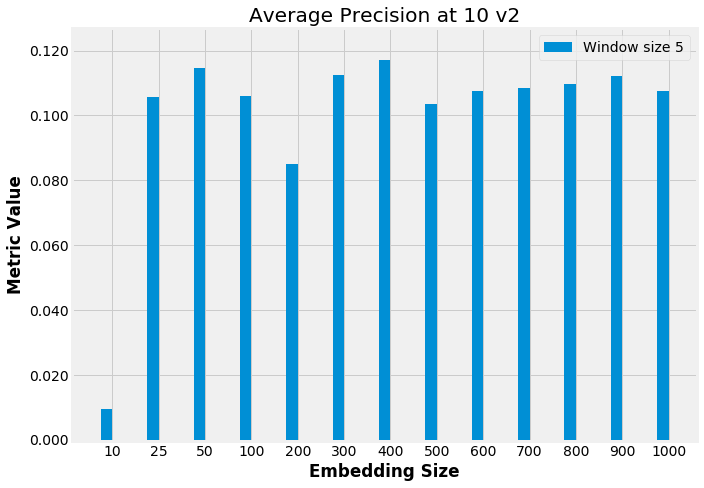

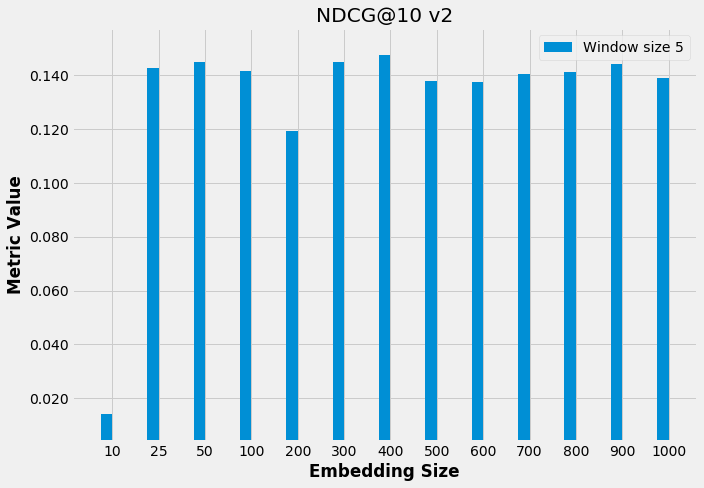

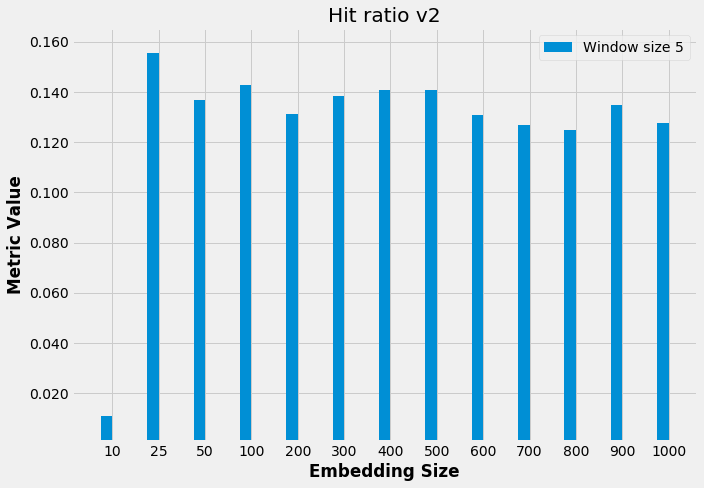

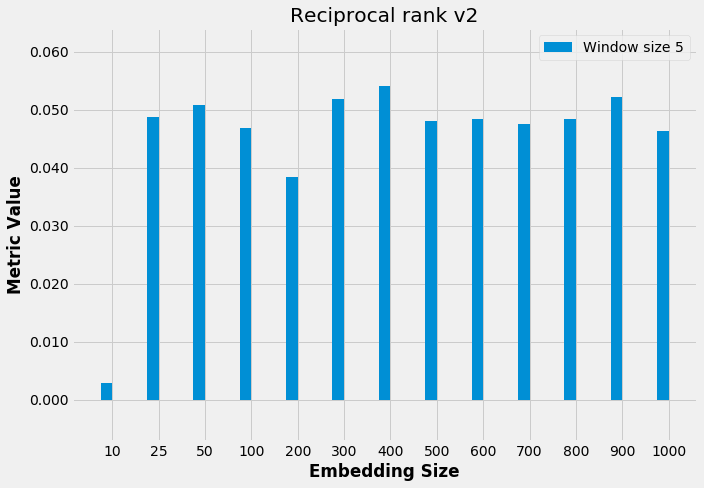

time: 2.15 s


In [14]:
graphs(w3_5449_r_average_precision_at_10, w5_5449_r_average_precision_at_10, w7_5449_r_average_precision_at_10, 'Average Precision at 10 for 5449')
graphs(w3_5449_r_ndcg_at_10, w5_5449_r_ndcg_at_10, w7_5449_r_ndcg_at_10, 'NDCG@10 for 5449')
graphs(w3_5449_s_hit_ratio, w5_5449_s_hit_ratio, w7_5449_s_hit_ratio, 'Hit ratio for 5449')
graphs(w3_5449_s_reciprocal_rank, w5_5449_s_reciprocal_rank, w7_5449_s_reciprocal_rank, 'Reciprocal rank for 5449')
